# Estudio de distintos modelos de pulso

La bibliografía estudiada [] sugiere que el uso de pulsos de rampa o binarios tienen resultados positivos en la terapia asociada. En el notebook presente se estudiarán los 3 pulsos más comunes en la literatura y se compará la diferencia de incremento de temperatura que producen.

In [1]:
import sys
sys.path.append('..')

import optimus
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from optimus.source.transducers import transducer_field
from optimus.postprocess.plot import surface_plot

from utilities import finite_difference, rectangular_pulse, turk_pulse

Dentro de los pulsos más usados se encuentra el pulso retangular, turk y continuo. Las características de cada uno se presentan a continuación.

## Pulso Rectangular

Pulso donde se activa la fuente por un tiempo $pd$ (period duration) y se apaga por un tiempo $pri-pd$ (period repetition interval). 

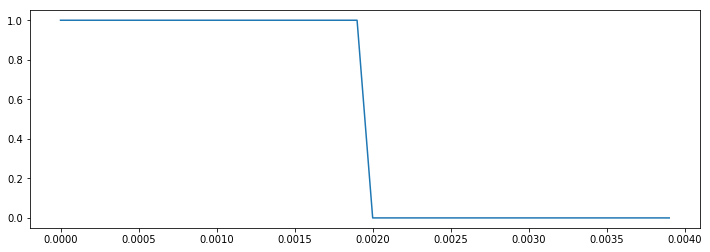

In [2]:
fig = plt.figure(figsize = (12,4))
time = np.arange(0, 4e-3, 1e-4)
amplitud_pulso = rectangular_pulse(time)
plt.plot(time, amplitud_pulso)

## Pulso Turk

Pulso donde se presenta una activación y desactivación sinusoidal de duración $rd$ (ramp duration) y donde en total, el pulso es no negativo durante un tiempo $pd$.

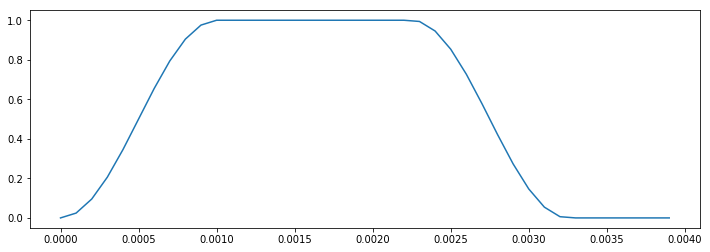

In [3]:
fig = plt.figure(figsize = (12,4))
time = np.arange(0, 4e-3, 1e-4)
amplitud_pulso = turk_pulse(time)
plt.plot(time, amplitud_pulso)

## Pulso Continuo

Pulso donde la fuente se encuentra encendidad en todo momento.

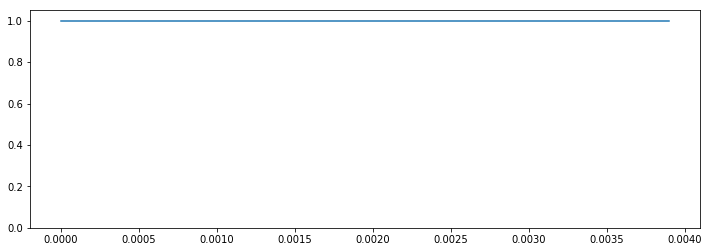

In [4]:
fig = plt.figure(figsize = (12,4))
time = np.arange(0, 4e-3, 1e-4)
plt.ylim(0, 1.05)
plt.plot(time, time * 0 + 1)

En lo que resta, se trabajará con el esquema usado en [], pero los resultados aplican de forma similar en otros esquemas. Se realizará una vez el esquema en cuestíon con los 3 pulsos, cada uno con los párametros obtenidos en []. Esto es con la idea de comparar la variación de temperatura con cada pulso asociado.

In [5]:
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')
IPP_abs_load = np.loadtxt("HEAD_0198 .txt")

c_0 = material_ext.speed_of_sound
rho_0 = material_ext.density
C_t = material_ext.heat_capacity 
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b 
alpha_0 = material_ext.attenuation_coeff_a 

frequency = 500e3

Nx = 51
Ny = 51
Nz = 101

xmin, xmax, ymin, ymax, zmin, zmax = [-0.03, 0.03, -0.03, 0.03, 0, 0.12]

delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_z = (zmax - zmin) / Nz

IPP_abs = IPP_abs_load.reshape(
    IPP_abs_load.shape[0], IPP_abs_load.shape[1] // 51, 51) 

intensity = (IPP_abs)**2 / (2 * c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
heat_deposition = intensity.copy()
heat_deposition = 2 * alpha * intensity

In [6]:
delta_t = 2e-5
Nt = int(1.5e4)
T_0 = np.zeros_like(heat_deposition) + 37

max_temp_ramp = []
max_temp_rect = []
max_temp_noat = []

prev_temp_ramp = T_0
prev_temp_rect = T_0
prev_temp_noat = T_0

time_domain = np.array(range(Nt)) * delta_t
rect_pulses = rectangular_pulse(time_domain)
ramp_pulses = turk_pulse(time_domain)

In [7]:
%%time
for i in range(Nt):
    max_temp_ramp.append(np.max(prev_temp_ramp))
    max_temp_rect.append(np.max(prev_temp_rect))
    max_temp_noat.append(np.max(prev_temp_noat))
    
    prev_temp_ramp = finite_difference(temp_grid=prev_temp_ramp, 
                                  heat_deposition=heat_deposition, 
                                  pulse_amplitude=ramp_pulses[i],
                                  delta_x=delta_x,
                                  delta_y=delta_y,
                                  delta_z=delta_z,
                                  delta_t=delta_t,
                                  initial_temp = 37,
                                  k_t = k_t,
                                  rho_0 = rho_0,
                                  C_t = C_t)
    
    prev_temp_rect = finite_difference(temp_grid=prev_temp_rect, 
                                  heat_deposition=heat_deposition, 
                                  pulse_amplitude=rect_pulses[i],
                                  delta_x=delta_x,
                                  delta_y=delta_y,
                                  delta_z=delta_z,
                                  delta_t=delta_t,
                                  initial_temp = 37,
                                  k_t = k_t,
                                  rho_0 = rho_0,
                                  C_t = C_t)
    
    prev_temp_noat = finite_difference(temp_grid=prev_temp_noat, 
                                  heat_deposition=heat_deposition, 
                                  pulse_amplitude=1,
                                  delta_x=delta_x,
                                  delta_y=delta_y,
                                  delta_z=delta_z,
                                  delta_t=delta_t,
                                  initial_temp = 37,
                                  k_t = k_t,
                                  rho_0 = rho_0,
                                  C_t = C_t)

CPU times: user 13min 11s, sys: 20.1 ms, total: 13min 11s
Wall time: 13min 11s


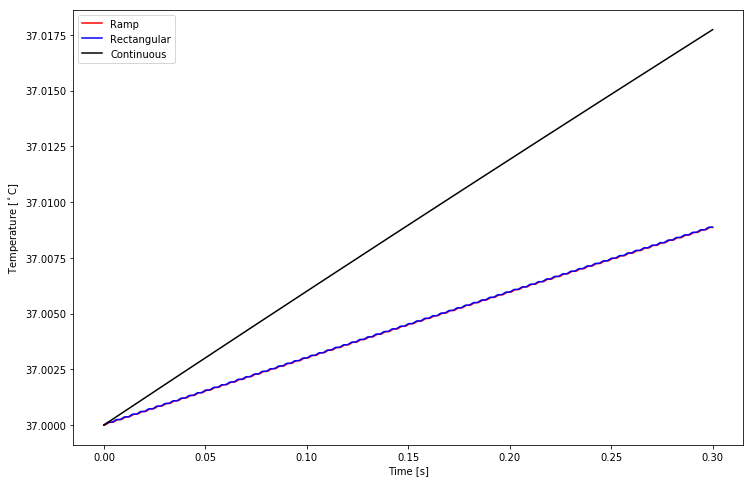

In [8]:
fig = plt.figure(figsize = (12,8))

plt.plot(time_domain, max_temp_ramp, c='red', label = 'Ramp')
plt.plot(time_domain, max_temp_rect, c='blue', label = 'Rectangular')
plt.plot(time_domain, max_temp_noat, c='black', label = 'Continuous') 

plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')
plt.show()

In [18]:
prop_rect = (37 - max_temp_noat[-1]) / (37 - max_temp_rect[-1])
prop_ramp = (37 - max_temp_noat[-1]) / (37 - max_temp_ramp[-1])
print('El pulso continuo aumenta', prop_rect, 'veces la temperatura en comparación con el pulso rectangular')
print('El pulso continuo aumenta', prop_ramp, 'veces la temperatura en comparación con el pulso rampa')

El pulso continuo aumenta 1.999106220632249 veces la temperatura en comparación con el pulso rectangular
El pulso continuo aumenta 1.999977051297518 veces la temperatura en comparación con el pulso rampa


## Comentarios
Dada la información presentada en los gráficos, se deduce lo siguiente:
- El pulso rectangular y turk son altamente comparables. Esto tiene sentido ya que $$
\int_{0}^{pri}f_{\text{Rect}}(t)^2dt=\int_{0}^{pri}f_{\text{Turk}}(t)^2dt=\frac{1}{2}pri
$$
donde $f_{\text{Rect}}(t)$ y $f_{\text{Turk}}(t)$ representan los pulsos rectangulares y turk en un instante $t$.

- El pulso continuo incrementa aproximadamente el doble la temperatura al compararlo con los otros dos pulsos. Esto se puede justificar ya que 
$$
\int_{0}^{pri}f_{\text{Cont}}(t)^2dt=pri=2\int_{0}^{pri}f_{\text{Rect}}(t)^2dt=2\int_{0}^{pri}f_{\text{Turk}}(t)^2dt
$$
- Existe un desface entre los pulsos rectangulares y turk. Esto puede deberse a que en pulso rectangular se entrega la mitad de la energía entre el tiempo $0$ y $pri\cdot 0.25$ y en el pulso turk esto ocurre entre los tiempos $0$ y $pri\cdot 0.40625$.

In [14]:
max_temp_rect[-1]

37.008867971297114